# Method 8 - Best Ideas High Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] > popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

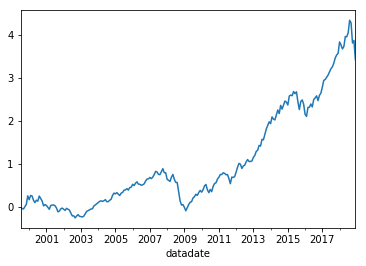

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.248078
2000-12-31   -0.162783
2001-12-31   -0.078400
2002-12-31   -0.198737
2003-12-31    0.379450
2004-12-31    0.232708
2005-12-31    0.105409
2006-12-31    0.133989
2007-12-31    0.085342
2008-12-31   -0.414073
2009-12-31    0.315029
2010-12-31    0.190111
2011-12-31    0.037596
2012-12-31    0.212956
2013-12-31    0.442979
2014-12-31    0.153805
2015-12-31   -0.013425
2016-12-31    0.075340
2017-12-31    0.255501
2018-12-31   -0.032797
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     545.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.88e-116
Time:                        06:26:34   Log-Likelihood:                 669.09
No. Observations:                 234   AIC:                            -1328.
Df Residuals:                     229   BIC:                            -1311.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.939      0.004       0.001       0.005
mktrf          0.9490      0.026     36.300      0.000       0.897       1.000
me             0.1990      0.030      6.542      0.000       0.139       0.259
ia            -0.2202      0.046     -4.765      0.000      -0.311      -0.129
roe            0.1250      0.040      3.160      0.002       0.047       0.203
==============================================================================
Omnibus:                       92.329   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1484.246
Skew:                           1.064   Prob(JB):                         0.00
Kurtosis:                      15.153   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     474.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.60e-109
Time:                        06:26:34   Log-Likelihood:                 669.09
No. Observations:                 234   AIC:                            -1328.
Df Residuals:                     229   BIC:                            -1311.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.077      0.002       0.001       0.005
mktrf          0.9490      0.027     35.142      0.000       0.896       1.002
me             0.1990      0.038      5.194      0.000       0.124       0.274
ia            -0.2202      0.120     -1.832      0.067      -0.456       0.015
roe            0.1250      0.052      2.390      0.017       0.023       0.227
==============================================================================
Omnibus:                       92.329   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1484.246
Skew:                           1.064   Prob(JB):                         0.00
Kurtosis:                      15.153   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     705.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.71e-127
Time:                        06:26:34   Log-Likelihood:                 669.09
No. Observations:                 234   AIC:                            -1328.
Df Residuals:                     229   BIC:                            -1311.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.909      0.004       0.001       0.005
mktrf          0.9490      0.025     37.732      0.000       0.900       0.998
me             0.1990      0.043      4.676      0.000       0.116       0.282
ia            -0.2202      0.107     -2.061      0.039      -0.430      -0.011
roe            0.1250      0.049      2.562      0.010       0.029       0.221
==============================================================================
Omnibus:                       92.329   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1484.246
Skew:                           1.064   Prob(JB):                         0.00
Kurtosis:                      15.153   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     406.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.27e-111
Time:                        06:26:34   Log-Likelihood:                 661.96
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.174      0.002       0.001       0.005
mktrf          0.9294      0.027     34.343      0.000       0.876       0.983
smb            0.1916      0.036      5.365      0.000       0.121       0.262
hml           -0.1030      0.042     -2.445      0.015      -0.186      -0.020
rmw            0.0370      0.048      0.777      0.438      -0.057       0.131
cma           -0.0795      0.061     -1.314      0.190      -0.199       0.040
==============================================================================
Omnibus:                       74.180   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1207.662
Skew:                           0.723   Prob(JB):                    5.75e-263
Kurtosis:                      14.035   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     638.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.11e-132
Time:                        06:26:34   Log-Likelihood:                 661.96
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.147      0.002       0.001       0.005
mktrf          0.9294      0.029     31.872      0.000       0.872       0.987
smb            0.1916      0.039      4.952      0.000       0.116       0.267
hml           -0.1030      0.057     -1.807      0.071      -0.215       0.009
rmw            0.0370      0.050      0.744      0.457      -0.060       0.134
cma           -0.0795      0.133     -0.599      0.549      -0.340       0.181
==============================================================================
Omnibus:                       74.180   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1207.662
Skew:                           0.723   Prob(JB):                    5.75e-263
Kurtosis:                      14.035   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     797.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.27e-142
Time:                        06:26:35   Log-Likelihood:                 661.96
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.992      0.003       0.001       0.005
mktrf          0.9294      0.029     32.032      0.000       0.873       0.986
smb            0.1916      0.038      5.078      0.000       0.118       0.265
hml           -0.1030      0.060     -1.709      0.087      -0.221       0.015
rmw            0.0370      0.043      0.859      0.391      -0.047       0.121
cma           -0.0795      0.135     -0.589      0.556      -0.344       0.185
==============================================================================
Omnibus:                       74.180   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1207.662
Skew:                           0.723   Prob(JB):                    5.75e-263
Kurtosis:                      14.035   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     684.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.78e-126
Time:                        06:26:35   Log-Likelihood:                 693.27
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1359.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.680      0.008       0.001       0.004
mktrf          1.0109      0.022     46.570      0.000       0.968       1.054
smb            0.1027      0.027      3.791      0.000       0.049       0.156
hml           -0.0549      0.027     -2.040      0.042      -0.108      -0.002
umd            0.1558      0.018      8.820      0.000       0.121       0.191
==============================================================================
Omnibus:                       54.582   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.081
Skew:                           0.655   Prob(JB):                     9.82e-87
Kurtosis:                       9.237   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     614.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.61e-121
Time:                        06:26:35   Log-Likelihood:                 693.27
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1359.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.718      0.007       0.001       0.004
mktrf          1.0109      0.029     35.098      0.000       0.954       1.067
smb            0.1027      0.029      3.528      0.000       0.046       0.160
hml           -0.0549      0.051     -1.083      0.279      -0.154       0.044
umd            0.1558      0.033      4.685      0.000       0.091       0.221
==============================================================================
Omnibus:                       54.582   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.081
Skew:                           0.655   Prob(JB):                     9.82e-87
Kurtosis:                       9.237   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     586.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.33e-119
Time:                        06:26:35   Log-Likelihood:                 693.27
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1359.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.853      0.004       0.001       0.004
mktrf          1.0109      0.029     34.522      0.000       0.953       1.068
smb            0.1027      0.026      4.014      0.000       0.053       0.153
hml           -0.0549      0.048     -1.143      0.253      -0.149       0.039
umd            0.1558      0.034      4.615      0.000       0.090       0.222
==============================================================================
Omnibus:                       54.582   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.081
Skew:                           0.655   Prob(JB):                     9.82e-87
Kurtosis:                       9.237   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     238.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.19e-54
Time:                        06:26:35   Log-Likelihood:                 321.65
No. Observations:                 120   AIC:                            -633.3
Df Residuals:                     115   BIC:                            -619.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.265      0.209      -0.001       0.005
mktrf          0.9852      0.044     22.564      0.000       0.899       1.072
me             0.2285      0.043      5.299      0.000       0.143       0.314
ia            -0.1940      0.068     -2.872      0.005      -0.328      -0.060
roe            0.1920      0.060      3.213      0.002       0.074       0.310
==============================================================================
Omnibus:                       60.706   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.711
Skew:                           1.368   Prob(JB):                    3.61e-131
Kurtosis:                      13.614   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     193.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.08e-50
Time:                        06:26:35   Log-Likelihood:                 321.65
No. Observations:                 120   AIC:                            -633.3
Df Residuals:                     115   BIC:                            -619.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.676      0.094      -0.000       0.004
mktrf          0.9852      0.042     23.672      0.000       0.904       1.067
me             0.2285      0.048      4.763      0.000       0.134       0.323
ia            -0.1940      0.150     -1.297      0.195      -0.487       0.099
roe            0.1920      0.057      3.370      0.001       0.080       0.304
==============================================================================
Omnibus:                       60.706   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.711
Skew:                           1.368   Prob(JB):                    3.61e-131
Kurtosis:                      13.614   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     278.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.65e-58
Time:                        06:26:35   Log-Likelihood:                 321.65
No. Observations:                 120   AIC:                            -633.3
Df Residuals:                     115   BIC:                            -619.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.652      0.099      -0.000       0.004
mktrf          0.9852      0.035     28.387      0.000       0.917       1.053
me             0.2285      0.053      4.342      0.000       0.125       0.332
ia            -0.1940      0.132     -1.469      0.142      -0.453       0.065
roe            0.1920      0.047      4.084      0.000       0.100       0.284
==============================================================================
Omnibus:                       60.706   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.711
Skew:                           1.368   Prob(JB):                    3.61e-131
Kurtosis:                      13.614   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     164.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.33e-50
Time:                        06:26:35   Log-Likelihood:                 314.17
No. Observations:                 120   AIC:                            -616.3
Df Residuals:                     114   BIC:                            -599.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.764      0.080      -0.000       0.007
mktrf          0.9618      0.049     19.543      0.000       0.864       1.059
smb            0.2250      0.056      4.037      0.000       0.115       0.335
hml           -0.1478      0.068     -2.164      0.033      -0.283      -0.013
rmw            0.0973      0.081      1.208      0.229      -0.062       0.257
cma            0.0074      0.088      0.083      0.934      -0.167       0.182
==============================================================================
Omnibus:                       39.766   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.097
Skew:                           0.760   Prob(JB):                     2.09e-72
Kurtosis:                      10.982   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     216.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.84e-56
Time:                        06:26:35   Log-Likelihood:                 314.17
No. Observations:                 120   AIC:                            -616.3
Df Residuals:                     114   BIC:                            -599.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      2.010      0.044    7.78e-05       0.006
mktrf          0.9618      0.057     16.968      0.000       0.851       1.073
smb            0.2250      0.053      4.284      0.000       0.122       0.328
hml           -0.1478      0.090     -1.640      0.101      -0.324       0.029
rmw            0.0973      0.080      1.213      0.225      -0.060       0.255
cma            0.0074      0.159      0.046      0.963      -0.304       0.319
==============================================================================
Omnibus:                       39.766   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.097
Skew:                           0.760   Prob(JB):                     2.09e-72
Kurtosis:                      10.982   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     226.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.75e-57
Time:                        06:26:35   Log-Likelihood:                 314.17
No. Observations:                 120   AIC:                            -616.3
Df Residuals:                     114   BIC:                            -599.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.888      0.059      -0.000       0.006
mktrf          0.9618      0.056     17.150      0.000       0.852       1.072
smb            0.2250      0.045      5.033      0.000       0.137       0.313
hml           -0.1478      0.098     -1.513      0.130      -0.339       0.044
rmw            0.0973      0.073      1.335      0.182      -0.046       0.240
cma            0.0074      0.158      0.047      0.963      -0.302       0.317
==============================================================================
Omnibus:                       39.766   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.097
Skew:                           0.760   Prob(JB):                     2.09e-72
Kurtosis:                      10.982   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     325.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-61
Time:                        06:26:35   Log-Likelihood:                 338.62
No. Observations:                 120   AIC:                            -667.2
Df Residuals:                     115   BIC:                            -653.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.342      0.021       0.000       0.006
mktrf          1.0585      0.033     31.697      0.000       0.992       1.125
smb            0.0845      0.038      2.223      0.028       0.009       0.160
hml           -0.0353      0.038     -0.928      0.355      -0.111       0.040
umd            0.1864      0.023      7.941      0.000       0.140       0.233
==============================================================================
Omnibus:                       26.256   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.530
Skew:                           0.548   Prob(JB):                     6.72e-27
Kurtosis:                       7.786   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     613.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-76
Time:                        06:26:35   Log-Likelihood:                 338.62
No. Observations:                 120   AIC:                            -667.2
Df Residuals:                     115   BIC:                            -653.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.071      0.002       0.001       0.005
mktrf          1.0585      0.036     29.109      0.000       0.987       1.130
smb            0.0845      0.034      2.491      0.013       0.018       0.151
hml           -0.0353      0.059     -0.603      0.547      -0.150       0.080
umd            0.1864      0.034      5.421      0.000       0.119       0.254
==============================================================================
Omnibus:                       26.256   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.530
Skew:                           0.548   Prob(JB):                     6.72e-27
Kurtosis:                       7.786   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     945.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.08e-87
Time:                        06:26:35   Log-Likelihood:                 338.62
No. Observations:                 120   AIC:                            -667.2
Df Residuals:                     115   BIC:                            -653.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.480      0.001       0.001       0.005
mktrf          1.0585      0.032     33.183      0.000       0.996       1.121
smb            0.0845      0.027      3.151      0.002       0.032       0.137
hml           -0.0353      0.056     -0.630      0.529      -0.145       0.075
umd            0.1864      0.030      6.295      0.000       0.128       0.245
==============================================================================
Omnibus:                       26.256   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.530
Skew:                           0.548   Prob(JB):                     6.72e-27
Kurtosis:                       7.786   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     410.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.46e-65
Time:                        06:26:35   Log-Likelihood:                 370.71
No. Observations:                 114   AIC:                            -731.4
Df Residuals:                     109   BIC:                            -717.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.810      0.000       0.002       0.006
mktrf          0.9330      0.028     33.137      0.000       0.877       0.989
me             0.1250      0.043      2.876      0.005       0.039       0.211
ia            -0.3348      0.060     -5.552      0.000      -0.454      -0.215
roe           -0.0607      0.053     -1.146      0.254      -0.166       0.044
==============================================================================
Omnibus:                        1.081   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                1.055
Skew:                           0.228   Prob(JB):                        0.590
Kurtosis:                       2.880   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     548.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.35e-71
Time:                        06:26:35   Log-Likelihood:                 370.71
No. Observations:                 114   AIC:                            -731.4
Df Residuals:                     109   BIC:                            -717.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.908      0.004       0.001       0.006
mktrf          0.9330      0.023     40.514      0.000       0.888       0.978
me             0.1250      0.044      2.832      0.005       0.039       0.212
ia            -0.3348      0.065     -5.127      0.000      -0.463      -0.207
roe           -0.0607      0.059     -1.027      0.304      -0.177       0.055
==============================================================================
Omnibus:                        1.081   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                1.055
Skew:                           0.228   Prob(JB):                        0.590
Kurtosis:                       2.880   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     769.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.98e-79
Time:                        06:26:35   Log-Likelihood:                 370.71
No. Observations:                 114   AIC:                            -731.4
Df Residuals:                     109   BIC:                            -717.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.695      0.007       0.001       0.006
mktrf          0.9330      0.021     43.714      0.000       0.891       0.975
me             0.1250      0.043      2.931      0.003       0.041       0.209
ia            -0.3348      0.069     -4.874      0.000      -0.469      -0.200
roe           -0.0607      0.052     -1.174      0.240      -0.162       0.041
==============================================================================
Omnibus:                        1.081   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                1.055
Skew:                           0.228   Prob(JB):                        0.590
Kurtosis:                       2.880   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     424.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.78e-69
Time:                        06:26:35   Log-Likelihood:                 384.99
No. Observations:                 114   AIC:                            -758.0
Df Residuals:                     108   BIC:                            -741.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.358      0.001       0.001       0.005
mktrf          0.9389      0.024     39.449      0.000       0.892       0.986
smb            0.1034      0.039      2.676      0.009       0.027       0.180
hml           -0.0481      0.049     -0.976      0.331      -0.146       0.050
rmw           -0.1370      0.060     -2.270      0.025      -0.257      -0.017
cma           -0.3418      0.077     -4.463      0.000      -0.494      -0.190
==============================================================================
Omnibus:                        0.429   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.807   Jarque-Bera (JB):                0.436
Skew:                           0.142   Prob(JB):                        0.804
Kurtosis:                       2.895   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     420.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.68e-69
Time:                        06:26:35   Log-Likelihood:                 384.99
No. Observations:                 114   AIC:                            -758.0
Df Residuals:                     108   BIC:                            -741.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.755      0.006       0.001       0.005
mktrf          0.9389      0.021     44.262      0.000       0.897       0.980
smb            0.1034      0.033      3.103      0.002       0.038       0.169
hml           -0.0481      0.046     -1.051      0.293      -0.138       0.042
rmw           -0.1370      0.047     -2.898      0.004      -0.230      -0.044
cma           -0.3418      0.082     -4.188      0.000      -0.502      -0.182
==============================================================================
Omnibus:                        0.429   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.807   Jarque-Bera (JB):                0.436
Skew:                           0.142   Prob(JB):                        0.804
Kurtosis:                       2.895   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     418.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.17e-69
Time:                        06:26:35   Log-Likelihood:                 384.99
No. Observations:                 114   AIC:                            -758.0
Df Residuals:                     108   BIC:                            -741.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.403      0.016       0.001       0.005
mktrf          0.9389      0.022     42.979      0.000       0.896       0.982
smb            0.1034      0.032      3.187      0.001       0.040       0.167
hml           -0.0481      0.045     -1.066      0.286      -0.137       0.040
rmw           -0.1370      0.052     -2.647      0.008      -0.238      -0.036
cma           -0.3418      0.066     -5.193      0.000      -0.471      -0.213
==============================================================================
Omnibus:                        0.429   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.807   Jarque-Bera (JB):                0.436
Skew:                           0.142   Prob(JB):                        0.804
Kurtosis:                       2.895   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     427.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.20e-65
Time:                        06:26:35   Log-Likelihood:                 372.88
No. Observations:                 114   AIC:                            -735.8
Df Residuals:                     109   BIC:                            -722.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.033      0.044    4.81e-05       0.004
mktrf          0.9654      0.026     36.873      0.000       0.913       1.017
smb            0.1316      0.041      3.224      0.002       0.051       0.213
hml           -0.1452      0.042     -3.453      0.001      -0.228      -0.062
umd            0.0472      0.032      1.487      0.140      -0.016       0.110
==============================================================================
Omnibus:                        0.482   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.153
Skew:                           0.012   Prob(JB):                        0.926
Kurtosis:                       3.178   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     678.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.09e-76
Time:                        06:26:35   Log-Likelihood:                 372.88
No. Observations:                 114   AIC:                            -735.8
Df Residuals:                     109   BIC:                            -722.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.828      0.068      -0.000       0.004
mktrf          0.9654      0.019     51.025      0.000       0.928       1.002
smb            0.1316      0.043      3.075      0.002       0.048       0.216
hml           -0.1452      0.032     -4.484      0.000      -0.209      -0.082
umd            0.0472      0.030      1.574      0.115      -0.012       0.106
==============================================================================
Omnibus:                        0.482   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.153
Skew:                           0.012   Prob(JB):                        0.926
Kurtosis:                       3.178   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1043.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.10e-86
Time:                        06:26:35   Log-Likelihood:                 372.88
No. Observations:                 114   AIC:                            -735.8
Df Residuals:                     109   BIC:                            -722.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.784      0.074      -0.000       0.004
mktrf          0.9654      0.017     56.557      0.000       0.932       0.999
smb            0.1316      0.046      2.861      0.004       0.041       0.222
hml           -0.1452      0.034     -4.228      0.000      -0.212      -0.078
umd            0.0472      0.032      1.484      0.138      -0.015       0.109
==============================================================================
Omnibus:                        0.482   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.153
Skew:                           0.012   Prob(JB):                        0.926
Kurtosis:                       3.178   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""